In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import category_encoders as ce

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
df_rad = pd.read_csv('./data1/sunshine.csv')

In [4]:
pd.date_range(start='2021-1-1 00:00:00',end='2021-11-6 23:00:00',freq='h').shape

(7440,)

In [5]:
from datetime import date
date.fromordinal(date(2021, 7, 1).toordinal() + 114 - 1)

datetime.date(2021, 10, 22)

In [6]:
df_we = pd.read_csv('./weather.csv')
df_we.index = pd.date_range(start='2021-7-1 00:00:00',end='2022-5-6 23:00:00',freq='h')
df_we = df_we.drop(['Day','Hour'],axis=1)
df_we = df_we.interpolate()
# df_we['Dir_sin'] = df_we.Dir.apply(lambda x:math.sin(math.pi*x/360))
# df_we['Dir_cos'] = df_we.Dir.apply(lambda x:math.cos(math.pi*x/360))
df_we.Dir = df_we.Dir/360

In [7]:
df_rad = pd.read_csv('./data1/sunshine.csv')

df_rad.index = df_we.index[(df_we.index.hour>5)&(df_we.index.hour<21)][:len(df_rad)]
df_rad = df_rad.drop(['Day','Hour'],axis=1)

df_rad = df_rad.join(pd.DataFrame(index=df_we.index),how='right')

df_rad.fillna(0,inplace=True)

df_rad.iloc[-10*24:]=np.nan

In [8]:
rad_daily = df_rad.values[:300*24].reshape(-1,24)
rad_daily = df_rad.rolling(1).mean().fillna(0).values[:300*24].reshape(-1,24)

# euc dist

In [9]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split

In [10]:
n_clusters = 2
hc = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
hc_labels = hc.fit_predict(rad_daily)

In [11]:
pd.Series(hc_labels).value_counts()

0    194
1    106
dtype: int64

In [12]:
hc_labels

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0], d

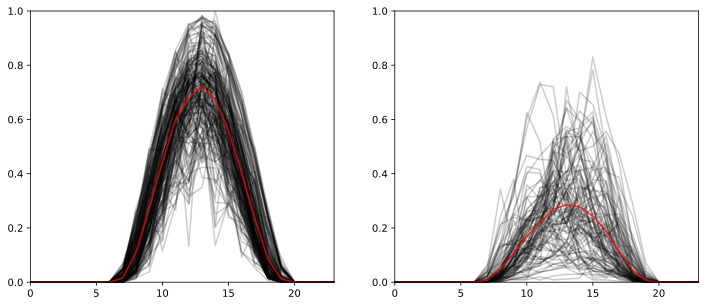

In [13]:
fig, axs = plt.subplots(1,n_clusters,figsize=(12,5))
axs[0].plot(rad_daily[hc_labels==0].T,c='k',alpha=0.2)
axs[0].plot(rad_daily[hc_labels==0].mean(axis=0),c='r',alpha=0.8)
axs[0].set_ylim(0,1)
axs[0].set_xlim(0,23)
axs[1].plot(rad_daily[hc_labels==1].T,c='k',alpha=0.2)
axs[1].plot(rad_daily[hc_labels==1].mean(axis=0),c='r',alpha=0.8)
axs[1].set_ylim(0,1)
axs[1].set_xlim(0,23)
plt.show()

In [14]:
we_daily = df_we.values.reshape(310,-1,df_we.shape[1])

test_size = 1

In [15]:
# MLP
from sklearn.neural_network import MLPClassifier
X = np.array([we_daily[i].T.flatten() for i in range(300)])
y = hc_labels

X_train, X_test, y_train, y_test = train_test_split(X, y,train_size = (300-test_size)/300,shuffle=False)
clf = MLPClassifier(hidden_layer_sizes=(100,25),random_state=10, max_iter=1200).fit(X_train, y_train)

clf.score(X_test, y_test)


1.0

In [16]:
import torch as T
from torch import nn

c:\users\q\appdata\local\programs\python\python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
class Dataset(T.utils.data.Dataset):
    def __init__(self, X,y):
        self.rnd = np.random.RandomState(2022)
        self.X = T.tensor(X,dtype=T.float32).to(device)
        X = X[:300]
        X_train, X_test, y_train, y_test = train_test_split(X, y,train_size = (300-test_size)/300,shuffle=False)
        
        self.X_train = T.tensor(X_train,dtype=T.float32).to(device)
        self.X_test = T.tensor(X_test,dtype=T.float32).to(device)
        self.y_train = T.tensor(y_train,dtype=T.float32).to(device)
        self.y_test = T.tensor(y_test,dtype=T.float32).to(device)
        self.n = len(self.y_train)        
    def __len__(self):
        return self.n

    def __getitem__(self,idx):
        return (self.X_train[idx], self.y_train[idx])

device = T.device('cpu')
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm1 = T.nn.LSTM(input_size=3, hidden_size=24,batch_first=True,num_layers=2,dropout=0.30)
        self.fc1 = T.nn.Linear(24, 1)
    def forward(self, x):
        h_n,(h_o,h_c) = self.lstm1(x) 
        #out = h_n[:,-1,:]
        out = h_o[-1]
        z = T.sigmoid(self.fc1(out))
        return z

In [18]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [19]:
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval
def find_opt_params(X,y,cat_features,max_evals=100,nfold=5):
    def int_params(params):
        params['n_estimators'] = int(params['n_estimators'])
        params['max_depth'] = int(params['max_depth'])
        params['num_leaves'] = int(params['num_leaves'])
        params['min_child_samples'] = int(params['min_child_samples'])
        params['n_estimators'] = int(params['n_estimators'])
        
        return params
    def objective_llf(params):
        params = int_params(params)
        params['verbose'] = -1
        cv_dateset = lgb.Dataset(X, y,categorical_feature = cat_features)
        llf = lgb.cv(params,cv_dateset,nfold=nfold,metrics='mse',return_cvbooster=True,stratified=False)
        y_pred = np.array(llf['cvbooster'].predict(X, num_iteration=llf['cvbooster'].best_iteration)).mean(axis=0)
        y_pred[y_pred<0]=0
        return mean_squared_error(y,y_pred)
    
    space_llf = {
                "objective": "regression",
                'n_estimators': hp.quniform('n_estimators',25,300,25 ),
                'max_depth':  hp.quniform('max_depth', 4,12,1),
                'num_leaves': hp.quniform('num_leaves', 5,30,1),
                'subsample': hp.uniform("subsample", 0.3, 1),
                'colsample_bytree': hp.uniform("colsample_bytree", 0.6, 1),
                'learning_rate': hp.loguniform('learning_rate', np.log(0.02), np.log(0.15)), # from 0.01 to 0.1
                'reg_alpha':  hp.uniform("reg_alpha", 0.1, 0.6),
                'reg_lambda':  hp.uniform("reg_lambda", 0.1, 0.6),
                'min_child_samples': hp.quniform("min_child_samples", 10, 70,5),
                'verbose': -1}
    best_llf = fmin(fn=objective_llf,
                    space=space_llf,
                    algo=tpe.suggest,
                    max_evals=max_evals)
    return int_params(best_llf)
def select_hours(df):
    return df.index[(df.index.hour>5)&(df.index.hour<21)]

In [20]:
seed = 2020
np.random.seed(seed)
T.manual_seed(seed)
X = we_daily
y = hc_labels
ds = Dataset(X,y)
data_ldr = T.utils.data.DataLoader(ds,batch_size=16, shuffle=True,drop_last=True)
net = Net()
optimizer = T.optim.Adam(net.parameters(), lr=0.001)   # optimize all cnn parameters
loss_func = nn.BCELoss()                       # the target label is not one-hotted



# training and testing
for epoch in range(150):
    for step, (b_x, b_y) in enumerate(data_ldr):        # gives batch data
        net.train()
        output = net(b_x)                               # rnn output
        loss = loss_func(output.view(len(b_y)), b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

    if epoch % 10 == 0:
        net.eval()
        pred_tr = T.round(net(ds.X_train).flatten()).data.numpy()
        accu_tr = sum(pred_tr == ds.y_train.data.numpy())/len(pred_tr)
        
        pred_te = T.round(net(ds.X_test).flatten()).data.numpy()
        accu_te = sum(pred_te == ds.y_test.data.numpy())/len(pred_te)
        
        print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| train accuracy: %.3f' % accu_tr, '| test accuracy: %.3f' % accu_te)

Epoch:  0 | train loss: 0.6274 | train accuracy: 0.645 | test accuracy: 1.000
Epoch:  10 | train loss: 0.5739 | train accuracy: 0.666 | test accuracy: 1.000
Epoch:  20 | train loss: 0.4980 | train accuracy: 0.696 | test accuracy: 1.000
Epoch:  30 | train loss: 0.4923 | train accuracy: 0.753 | test accuracy: 1.000
Epoch:  40 | train loss: 0.8422 | train accuracy: 0.799 | test accuracy: 0.000
Epoch:  50 | train loss: 0.4669 | train accuracy: 0.829 | test accuracy: 1.000
Epoch:  60 | train loss: 0.2244 | train accuracy: 0.843 | test accuracy: 1.000
Epoch:  70 | train loss: 0.3328 | train accuracy: 0.849 | test accuracy: 1.000
Epoch:  80 | train loss: 0.2997 | train accuracy: 0.876 | test accuracy: 1.000
Epoch:  90 | train loss: 0.1681 | train accuracy: 0.906 | test accuracy: 1.000
Epoch:  100 | train loss: 0.1914 | train accuracy: 0.893 | test accuracy: 1.000
Epoch:  110 | train loss: 0.1658 | train accuracy: 0.906 | test accuracy: 1.000
Epoch:  120 | train loss: 0.1215 | train accuracy: 

In [21]:
net.eval()
hc_labels_te_pred = T.round(net(ds.X_test)).squeeze().data.numpy().astype(int)
hc_labels_te_pred == ds.y_test.data.numpy(),sum(hc_labels_te_pred == ds.y_test.data.numpy())/test_size

(array([ True]), 1.0)

In [22]:
df_we_fe = df_we.copy()

df_we_fe['Tem_shift1'] = df_we_fe.Temp.shift(1)
df_we_fe['Dir_shift1'] = df_we_fe.Dir.shift(1)
df_we_fe['Spd_shift1'] = df_we_fe.Spd.shift(1)



df_we_fe['Tem_shift24'] = df_we_fe.Temp.shift(24)
df_we_fe['Dir_shift24'] = df_we_fe.Dir.shift(24)
df_we_fe['Spd_shift24'] = df_we_fe.Spd.shift(24)

df_we_fe['Tem_roll3'] = df_we_fe.Temp.rolling(3).mean()
df_we_fe['Dir_roll3'] = df_we_fe.Dir.rolling(3).mean()
df_we_fe['Spd_roll3'] = df_we_fe.Spd.rolling(3).mean()

df_we_fe['Tem_shift_roll24'] = df_we_fe.Temp.rolling(24).mean()
df_we_fe['Dir_shift_roll24'] = df_we_fe.Dir.rolling(24).mean()
df_we_fe['Spd_shift_roll24'] = df_we_fe.Spd.rolling(24).mean()

df_we_fe['Tem_shift_roll168'] = df_we_fe.Temp.rolling(168).mean()
df_we_fe['Dir_shift_roll168'] = df_we_fe.Dir.rolling(168).mean()
df_we_fe['Spd_shift_roll168'] = df_we_fe.Spd.rolling(168).mean()


df_we_fe['Tem_shift_roll720'] = df_we_fe.Temp.rolling(720).mean()
df_we_fe['Dir_shift_roll720'] = df_we_fe.Dir.rolling(720).mean()
df_we_fe['Spd_shift_roll720'] = df_we_fe.Spd.rolling(720).mean()

df_we_fe['Tem_shift_roll1'] = df_we_fe.Temp.rolling(3).mean().shift(24)
df_we_fe['Dir_shift_roll1'] = df_we_fe.Dir.rolling(3).mean().shift(24)
df_we_fe['Spd_shift_roll1'] = df_we_fe.Spd.rolling(3).mean().shift(24)

df_we_fe['Tem_shift_roll2'] = df_we_fe.Temp.rolling(24).mean().shift(24)
df_we_fe['Dir_shift_roll2'] = df_we_fe.Dir.rolling(24).mean().shift(24)
df_we_fe['Spd_shift_roll2'] = df_we_fe.Spd.rolling(24).mean().shift(24)

df_we_fe['Tem_shift_roll3'] = df_we_fe.Temp.rolling(72).mean().shift(72)
df_we_fe['Dir_shift_roll3'] = df_we_fe.Dir.rolling(72).mean().shift(72)
df_we_fe['Spd_shift_roll3'] = df_we_fe.Spd.rolling(72).mean().shift(72)






df_we_fe = df_we_fe.fillna(-99)

df_we_fe['hour'] = df_we_fe.index.hour

# df_we_fe['hour_sin'] = df_we_fe.hour.apply(lambda x:math.sin(math.pi*x/12))

df_we_fe['day_of_week'] = df_we_fe.index.day_of_week

df_we_fe['month'] = df_we_fe.index.month

df_we_fe['week'] = df_we_fe.index.isocalendar().week
df_we_fe.week = df_we_fe.week.astype(int)

hc_labels_pred = T.round(net(ds.X)).squeeze().data.numpy().astype(int)

# manually change the last test day rad_label_pred from 0 to 1, should be careful
hc_labels_pred[-1] = 1

df_we_fe['Rad_label_pred'] = np.repeat(hc_labels_pred,24)
# df_we_fe['Rad_label_true'] = df_we_fe['Rad_label_pred']
# df_we_fe['Rad_label_true'].iloc[:7200] = np.repeat(hc_labels,24)

def Dir_label(Dir):
    label = round(Dir*360/45)
    return label if label !=8 else 7
df_we_fe['Dir_label'] = df_we.Dir.apply(Dir_label)


In [23]:
df_we_fe.select_dtypes(include=['int']).columns

Index(['hour', 'day_of_week', 'month', 'week', 'Rad_label_pred', 'Dir_label'], dtype='object')

In [24]:
# drop_cols = ['Rad_label_true']
drop_cols = []
df_we_fe_ = df_we_fe.drop(drop_cols,axis=1)

In [25]:
cat_features = []#df_we_fe.select_dtypes(include=['int']).columns.to_list()
X_train_, X_test_, y_train, y_test = train_test_split(df_we_fe_[:7200], df_rad[:7200],train_size = (300-test_size)/300,shuffle=False)
X_sub = df_we_fe_[7200:]

In [26]:
cols = X_train_.select_dtypes(include=['int']).columns
ce_te = ce.TargetEncoder(cols=cols)
ce_cb = ce.CatBoostEncoder(cols=cols)

c:\users\q\appdata\local\programs\python\python38\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
c:\users\q\appdata\local\programs\python\python38\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [27]:
ce_te.fit(X_train_,y_train)
te_added = ce_te.transform(X_train_)[cols].add_suffix('_te')
te_added_test = ce_te.transform(X_test_)[cols].add_suffix('_te')
te_added_sub = ce_te.transform(X_sub)[cols].add_suffix('_te')
X_train_ = pd.concat([X_train_,te_added],axis=1)
X_test_ = pd.concat([X_test_,te_added_test],axis=1)
X_sub = pd.concat([X_sub,te_added_sub],axis=1)

In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
nfold = 10
X_train = X_train_.copy()
X_test = X_test_.copy()
best_params = find_opt_params(X_train.loc[select_hours(X_train)],y_train.loc[select_hours(X_train)],cat_features=cat_features,max_evals=60,nfold=nfold)
best_params['verbose'] = -1

cv_dateset = lgb.Dataset(X_train.loc[select_hours(X_train)],y_train.loc[select_hours(X_train)],categorical_feature = cat_features)
llf = lgb.cv(best_params,cv_dateset,nfold=nfold,metrics='mse',return_cvbooster=True,stratified=False)

y_train_true = y_train.loc[select_hours(X_train)].values
y_train_pred = np.array(llf['cvbooster'].predict(X_train.loc[select_hours(X_train)], num_iteration=llf['cvbooster'].best_iteration)).mean(axis=0)
y_train_pred[y_train_pred<0]=0
mean_squared_error(y_train_true,y_train_pred)

y_test_true = y_test.loc[select_hours(X_test)].values
y_test_pred = np.array(llf['cvbooster'].predict(X_test.loc[select_hours(X_test)], num_iteration=llf['cvbooster'].best_iteration)).mean(axis=0)
y_test_pred[y_test_pred<0]=0
mean_squared_error(y_test_true,y_test_pred)

round(mean_squared_error(y_train_true,y_train_pred),5),round(mean_squared_error(y_test_true,y_test_pred),5)

100%|██████████████████████████████████████████████| 60/60 [08:21<00:00,  8.36s/trial, best loss: 0.000805663749821752]


(0.00081, 0.01894)

In [30]:
X_sub

,Temp,Dir,Spd,Tem_shift1,Dir_shift1,Spd_shift1,Tem_shift24,Dir_shift24,Spd_shift24,Tem_roll3,...,month,week,Rad_label_pred,Dir_label,hour_te,day_of_week_te,month_te,week_te,Rad_label_pred_te,Dir_label_te
2022-04-27 00:00:00,0.518771,0.333333,0.411765,0.518771,0.333333,0.362745,0.494881,0.305556,0.421569,0.519909,...,4,17,1,3,0.000000,0.155614,0.123698,0.098583,0.083671,0.203034
2022-04-27 01:00:00,0.518771,0.333333,0.372549,0.518771,0.333333,0.411765,0.477816,0.305556,0.411765,0.518771,...,4,17,1,3,0.000000,0.155614,0.123698,0.098583,0.083671,0.203034
2022-04-27 02:00:00,0.515358,0.333333,0.382353,0.518771,0.333333,0.372549,0.477816,0.305556,0.460784,0.517634,...,4,17,1,3,0.000000,0.155614,0.123698,0.098583,0.083671,0.203034
2022-04-27 03:00:00,0.518771,0.333333,0.382353,0.515358,0.333333,0.382353,0.474403,0.305556,0.431373,0.517634,...,4,17,1,3,0.000000,0.155614,0.123698,0.098583,0.083671,0.203034
2022-04-27 04:00:00,0.522184,0.333333,0.431373,0.518771,0.333333,0.382353,0.460751,0.305556,0.401961,0.518771,...,4,17,1,3,0.000000,0.155614,0.123698,0.098583,0.083671,0.203034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-06 19:00:00,0.757679,0.555556,0.156863,0.761092,0.583333,0.156863,0.621160,0.305556,0.117647,0.769056,...,5,18,1,4,0.009783,0.163483,0.158484,0.158484,0.083671,0.158168
2022-05-06 20:00:00,0.750853,0.583333,0.098039,0.757679,0.555556,0.156863,0.610922,0.305556,0.156863,0.756542,...,5,18,1,5,0.000010,0.163483,0.158484,0.158484,0.083671,0.189071
2022-05-06 21:00:00,0.744027,0.722222,0.029412,0.750853,0.583333,0.098039,0.607509,0.305556,0.176471,0.750853,...,5,18,1,6,0.000000,0.163483,0.158484,0.158484,0.083671,0.213804
2022-05-06 22:00:00,0.723549,0.527778,0.078431,0.744027,0.722222,0.029412,0.607509,0.305556,0.196078,0.739477,...,5,18,1,4,0.000000,0.163483,0.158484,0.158484,0.083671,0.158168


In [31]:
Y_sub = np.array(llf['cvbooster'].predict(X_sub.loc[select_hours(X_sub)], num_iteration=llf['cvbooster'].best_iteration)).mean(axis=0)
Y_sub[Y_sub<0]=0

In [32]:
np.arange(0,240, 24)

array([  0,  24,  48,  72,  96, 120, 144, 168, 192, 216])

In [33]:
X_sub.Rad_label_pred[np.arange(0,240, 24)]

2022-04-27    1
2022-04-28    0
2022-04-29    1
2022-04-30    0
2022-05-01    1
2022-05-02    1
2022-05-03    1
2022-05-04    1
2022-05-05    1
2022-05-06    1
Freq: 24H, Name: Rad_label_pred, dtype: int32

In [34]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=False).get_n_splits(X_train_)
    rmse= np.sqrt(-cross_val_score(model, X_train_, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse*rmse)

In [35]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [36]:
rf = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators= 160, max_depth=60, max_features = "auto", random_state=10))
score_rf = rmsle_cv(rf).mean()
print("mse_cv=", score_rf )

mse_cv= 0.008590569490914302


In [37]:
model_lgb = lgb.LGBMRegressor()
score_model_lgb = rmsle_cv(model_lgb).mean()
print("mse_cv=", score_model_lgb)
warnings.filterwarnings("ignore")

mse_cv= 0.007995419040926727


In [38]:
model_xgb = xgb.XGBRegressor()
score_model_xgb = rmsle_cv(model_xgb).mean()
print("mse_cv=", score_model_xgb)

mse_cv= 0.009439366773116537


In [39]:
X_train_.shape[1]

42

In [40]:
# design lstm network
'''from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(300, activation='sigmoid', input_shape=(1, X_train_.shape[1])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])

# fit network
history = model.fit(X_train_.values.reshape((X_train_.shape[0], 1, X_train_.shape[1])), np.array(y_train).reshape((y_train.shape[0],1)), epochs=100, batch_size=60, verbose=0,validation_data=(X_test_.values.reshape((X_test_.shape[0], 1, X_test_.shape[1])), np.array(y_test).reshape((y_test.shape[0],1))), shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
y_prediction_lstm = model.predict(X_sub.values.reshape((X_sub.shape[0], 1, X_sub.shape[1])))
y_prediction_lstm =y_prediction_lstm.reshape(len(y_prediction_lstm))
y_prediction_lstm[y_prediction_lstm<0]=0

y_vali_lstm = model.predict(X_test_.values.reshape((X_test_.shape[0], 1, X_test_.shape[1])))
y_vali_lstm = y_vali_lstm.reshape(len(y_vali_lstm))
MSE = mean_squared_error(y_test, y_vali_lstm)
print(MSE)'''

"from keras.models import Sequential\nfrom keras.layers import Dense\nfrom keras.layers import LSTM\nmodel = Sequential()\nmodel.add(LSTM(300, activation='sigmoid', input_shape=(1, X_train_.shape[1])))\nmodel.add(Dense(1))\nmodel.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])\n\n# fit network\nhistory = model.fit(X_train_.values.reshape((X_train_.shape[0], 1, X_train_.shape[1])), np.array(y_train).reshape((y_train.shape[0],1)), epochs=100, batch_size=60, verbose=0,validation_data=(X_test_.values.reshape((X_test_.shape[0], 1, X_test_.shape[1])), np.array(y_test).reshape((y_test.shape[0],1))), shuffle=False)\n\n# plot history\nplt.plot(history.history['loss'], label='train')\nplt.plot(history.history['val_loss'], label='test')\nplt.legend()\nplt.show()\n\n# make a prediction\ny_prediction_lstm = model.predict(X_sub.values.reshape((X_sub.shape[0], 1, X_sub.shape[1])))\ny_prediction_lstm =y_prediction_lstm.reshape(len(y_prediction_lstm))\ny_prediction_lstm[y_prediction_lstm

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [42]:
# stacking approach
stacked_averaged_models = StackingAveragedModels(base_models = (rf, model_xgb),
                                                 meta_model = model_lgb)

In [43]:
def msle(y, y_pred):
    return mean_squared_error(y, y_pred)

In [44]:
stacked_averaged_models.fit(X_train_.values, y_train.values)
stacked_train_pred = stacked_averaged_models.predict(X_test_)
stacked_pred = stacked_averaged_models.predict(X_sub.loc[select_hours(X_sub)])
print(msle(y_test, stacked_train_pred))

0.009199442515365653


# bagging approach

In [45]:
# RF
rf.fit(X_train_.values, y_train.values)
rf_sub = rf.predict(X_sub.loc[select_hours(X_sub)])
rf_sub[rf_sub<0] = 0

In [46]:
# lightgbm
model_lgb.fit(X_train_.values, y_train.values)
lgb_sub = model_lgb.predict(X_sub.loc[select_hours(X_sub)])
lgb_sub[lgb_sub<0] = 0

mse_stacking= 0.009199442515365653
mse_lgb_cz= 0.011851872980771639
mse_rf= 0.008718925191069591
mse_lgb= 0.01883315583393347


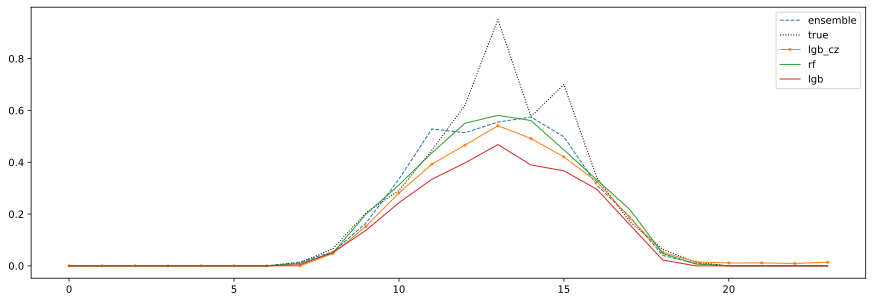

In [47]:
# plot the validation results
plt.figure(figsize=(15, 5))
plt.plot(stacked_train_pred, '--', label='ensemble',  linewidth=1)
plt.plot(y_test.values, 'black', linestyle=':', label='true', linewidth=1)
lgb_cz_vali = np.array(llf['cvbooster'].predict(X_test, num_iteration=llf['cvbooster'].best_iteration)).mean(axis=0)
lgb_cz_vali[lgb_cz_vali<0] = 0
plt.plot(lgb_cz_vali, label='lgb_cz', linewidth=1, marker = 'o', markersize = 2)
rf_vali = rf.predict(X_test_)
rf_vali[rf_vali<0] = 0
plt.plot(rf_vali, label='rf', linewidth=1)
lgb_vali = model_lgb.predict(X_test_)
lgb_vali[lgb_vali<0]=0
plt.plot(lgb_vali, label='lgb', linewidth=1)
# plt.plot(y_vali_lstm, label='lstm')
plt.legend()
print("mse_stacking=", msle(y_test, stacked_train_pred))
print("mse_lgb_cz=", msle(y_test, lgb_cz_vali))
print("mse_rf=", msle(y_test, rf_vali))
print("mse_lgb=", msle(y_test, lgb_vali))

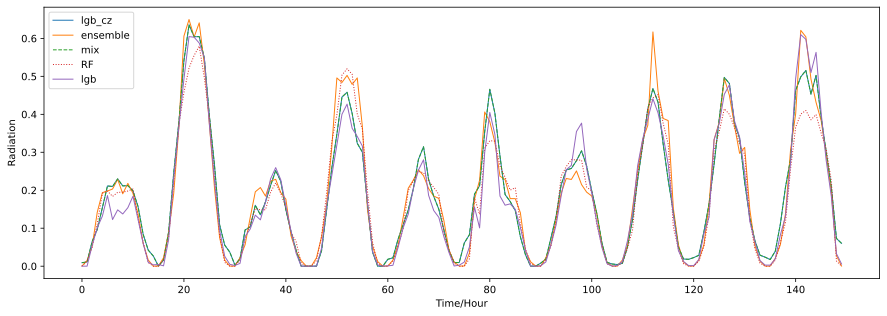

In [48]:
# plot the test results
y_test_final = pd.DataFrame()
# do bagging
k0 = 0.0
k_rf = 0.0
results = (stacked_pred)*k0 + Y_sub*(1-k0-k_rf) + rf_sub*k_rf

# day by day ensemble
'''days = [1]
hours = 15
for i in days:
    results[hours*i:hours*(i+1)] = rf_sub[hours*i:hours*(i+1)]'''

y_test_final['Radiation'] = results
y_test_final.to_csv('./sunshine_pred.csv', index=False)

plt.figure(figsize=(15, 5))
plt.plot(Y_sub, label='lgb_cz',linewidth=1)
plt.plot(stacked_pred, label='ensemble',linewidth=1)
plt.plot(y_test_final, '--', label='mix',linewidth=1)
plt.plot(rf_sub,  linestyle=':', label='RF',linewidth=1)
plt.plot(lgb_sub, label='lgb',linewidth=1)
# plt.plot(y_prediction_lstm, label='lstm')
plt.xlabel('Time/Hour')
plt.ylabel('Radiation')
plt.legend()

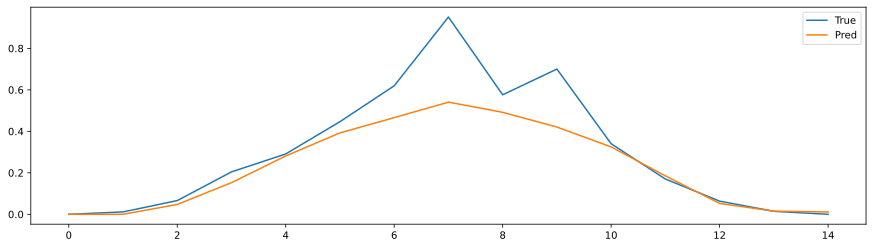

In [49]:
plt.figure(figsize=(15,4))
plt.plot(y_test_true,label='True')
plt.plot(y_test_pred,label='Pred')
plt.legend()

<AxesSubplot:>

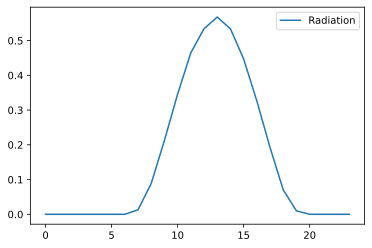

In [50]:
df_rad.groupby(df_rad.index.hour).mean().plot()

<AxesSubplot:>

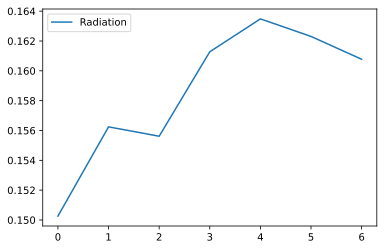

In [51]:
df_rad.groupby(df_rad.index.day_of_week).mean().plot()

<AxesSubplot:>

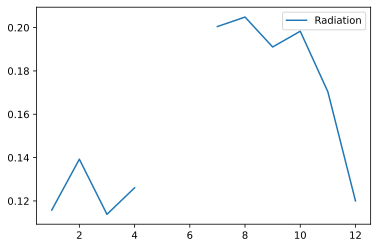

In [52]:
df_rad.groupby(df_rad.index.month).mean().plot()

<AxesSubplot:>

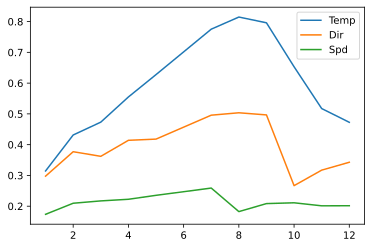

In [53]:
df_we.groupby(df_rad.index.month).mean().plot()

In [54]:
device = T.device('cpu')
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.lstm1 = T.nn.LSTM(input_size=3, hidden_size=24,batch_first=True)#,num_layers=2,dropout=0.25)
        self.drop1 = T.nn.Dropout(0.3)
        self.norm1 = T.nn.BatchNorm1d(24)
        self.lstm2 = T.nn.LSTM(input_size=24, hidden_size=48,batch_first=True)#,num_layers=2,dropout=0.25)
        self.drop2 = T.nn.Dropout(0.3)
        self.norm2 = T.nn.BatchNorm1d(48)
        
        self.fc1 = T.nn.Linear(48, 20)
        self.drop3 = T.nn.Dropout(0.3)
        self.norm3 = T.nn.BatchNorm1d(20)
        self.fc2 = T.nn.Linear(20, 1)

    def forward(self, x):
        z,_ = self.lstm1(x)   # Size([bs, 64, 56])
        z = self.drop1(z)
        
        z = z.permute(0, 2, 1)
        z = self.norm1(z)
        z = z.permute(0, 2, 1)
        
        _,(z,_) = self.lstm2(z)   # Size([bs, 64, 56])
        z = z[-1]
        z = self.drop2(z)
        z = self.norm2(z)
        
        z = T.relu(self.fc1(z))
        
        z = self.drop3(z)
        
        z = self.norm3(z)

        z = T.sigmoid(self.fc2(z))
        return z